In [1]:
%pylab inline
import pandas as pd
import numpy as np

frame = pd.read_csv("churn_analysis.csv", sep=",", header=0)
frame.head()

Populating the interactive namespace from numpy and matplotlib


,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [2]:
control_group = frame[frame["treatment"] == 1]
states = list(set(control_group["state"].values))
control_states_pivot = pd.pivot_table(
    control_group,
    values=["treatment"],
    index=["state"],
    columns=["churn"],
    fill_value = 0,
    aggfunc='count')

not_enough_data_count = len(filter(lambda val: val < 5, control_states_pivot.loc[:,[False, True]].values))
not_enough_data_count += len(filter(lambda val: val < 5, control_states_pivot.loc[:,[True, False]].values))
print "Count of cells where is not enough data is %i. The percent of these cells is %.2f%%" % (not_enough_data_count, float(not_enough_data_count)/(control_states_pivot.shape[0]*control_states_pivot.shape[1])*100)


from scipy import stats
def calculate_pairwise_diffs(pivot_table, states, stat_calculator):
    states_count = len(states)
    result = []
    for i in xrange(states_count-1):
        first_state = states[i]
        for j in xrange(i+1, states_count):
            second_state = states[j]
            chi_2_stat = stat_calculator(pivot_table.loc[[first_state,second_state],:])
            result.append(chi_2_stat)
    return result
def stats_compare_plot(control_stat, validate_stat):
    sorted_stats,sorted_stats_corrected = zip(*sorted(
        map(
            lambda (stat, c_stat): (stat[1],c_stat[1]),
            zip(control_stat,validate_stat)),
        key=(lambda (stat, c_stat): stat)))
    sorted_stats_x,sorted_stats_y=zip(*enumerate(sorted_stats))
    sorted_stats_corrected_x,sorted_stats_corrected_y=zip(*enumerate(sorted_stats_corrected))
    pylab.xlim(0,len(sorted_stats))
    pylab.scatter(sorted_stats_x, sorted_stats_y, color="r", alpha=.5)
    pylab.scatter(sorted_stats_corrected_x, sorted_stats_corrected_y, color="g", alpha=.5)
    pylab.show()
    
def chi_2_stat_no_correction(table):
    return stats.chi2_contingency(table, correction=False)
chi_2_stats = calculate_pairwise_diffs(control_states_pivot, states, chi_2_stat_no_correction)


print "A number of cells where p-value is less than 0.05 for chi-square criterion: %i" % len(filter(lambda stat: stat[1] < 0.05, chi_2_stats))

Count of cells where is not enough data is 34. The percent of these cells is 33.33%
A number of cells where p-value is less than 0.05 for chi-square criterion: 34


In [3]:
def chi_2_stat_correction(table):
    return stats.chi2_contingency(table, correction=True)
chi_2_corrected_stats = calculate_pairwise_diffs(control_states_pivot, states, chi_2_stat_correction)
print "A number of cells where p-value is less than 0.05 for chi-square criterion with correction: %i" % len(filter(lambda stat: stat[1] < 0.05, chi_2_corrected_stats))

A number of cells where p-value is less than 0.05 for chi-square criterion with correction: 0


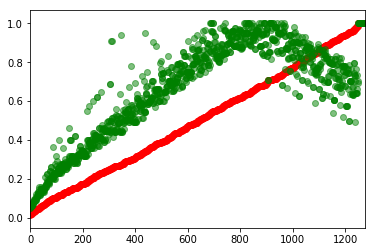

A number of corrected stats where p-value is greater than p-value without correction is 1054. Percentage: 82.67
A number of corrected stats where p-value is less than p-value without correction is 192. Percentage: 15.06


In [4]:
corrected_stats_greater_count = len(filter(lambda(stat, corrected): corrected[1] > stat[1], zip(chi_2_stats, chi_2_corrected_stats)))
corrected_stats_less_count = len(filter(lambda(stat, corrected): corrected[1] < stat[1], zip(chi_2_stats, chi_2_corrected_stats)))
stats_compare_plot(chi_2_stats, chi_2_corrected_stats)

print "A number of corrected stats where p-value is greater than p-value without correction is %i. Percentage: %.2f" % (corrected_stats_greater_count, float(corrected_stats_greater_count)/len(chi_2_stats)*100)
print "A number of corrected stats where p-value is less than p-value without correction is %i. Percentage: %.2f" % (corrected_stats_less_count, float(corrected_stats_less_count)/len(chi_2_stats)*100)

A number of cells where p-value is less than 0.05 for Fischer criterion: 10


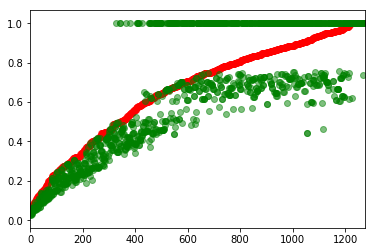

A number of Fischer stats where p-value is greater than p-value chi-square with correction is 453. Percentage: 35.53
A number of Fischer stats where p-value is less than p-value chi-square with correction is 767. Percentage: 60.16


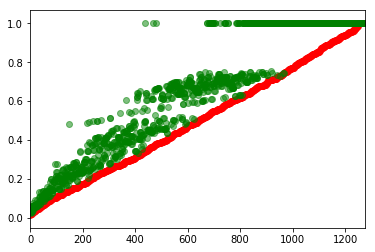

A number of Fischer stats where p-value is greater than p-value chi-square is 1247. Percentage: 97.80
A number of Fischer stats where p-value is less than p-value chi-square is 2. Percentage: 0.16
Average difference between chi2 stat and fischer stat is 0.1465


In [5]:
def fisher_exact_stat(table):
    return stats.fisher_exact(table, alternative="two-sided")


fischer_stats = calculate_pairwise_diffs(control_states_pivot, states, fisher_exact_stat)
fischer_stats_greater_count_c = len(filter(lambda(corrected, fischer): fischer[1] > corrected[1], zip(chi_2_corrected_stats, fischer_stats)))
fischer_stats_less_count_c = len(filter(lambda(corrected, fischer): fischer[1] < corrected[1], zip(chi_2_corrected_stats, fischer_stats)))
fischer_stats_greater_count = len(filter(lambda(stat, fischer): fischer[1] > stat[1], zip(chi_2_stats, fischer_stats)))
fischer_stats_less_count = len(filter(lambda(stat, fischer): fischer[1] < stat[1], zip(chi_2_stats, fischer_stats)))

print "A number of cells where p-value is less than 0.05 for Fischer criterion: %i" % len(filter(lambda stat: stat[1] < 0.05, fischer_stats))
stats_compare_plot(chi_2_corrected_stats, fischer_stats)
print "A number of Fischer stats where p-value is greater than p-value chi-square with correction is %i. Percentage: %.2f" % (fischer_stats_greater_count_c, float(fischer_stats_greater_count_c)/len(fischer_stats)*100)
print "A number of Fischer stats where p-value is less than p-value chi-square with correction is %i. Percentage: %.2f" % (fischer_stats_less_count_c, float(fischer_stats_less_count_c)/len(fischer_stats)*100)
stats_compare_plot(chi_2_stats, fischer_stats)
print "A number of Fischer stats where p-value is greater than p-value chi-square is %i. Percentage: %.2f" % (fischer_stats_greater_count, float(fischer_stats_greater_count)/len(fischer_stats)*100)
print "A number of Fischer stats where p-value is less than p-value chi-square is %i. Percentage: %.2f" % (fischer_stats_less_count, float(fischer_stats_less_count)/len(fischer_stats)*100)
avg_diff = np.average(map(lambda (chi2_stat, fischer_stat): fischer_stat[1]-chi2_stat[1], zip(chi_2_stats,fischer_stats)))
print "Average difference between chi2 stat and fischer stat is %.4f" % avg_diff

In [6]:
from scipy.stats import t
def student_criterion(correlation, count):
    corr = float(np.abs(correlation))
    cnt = float(count)
    stat = corr*np.sqrt(cnt-2.)/np.sqrt(1.-corr**2.)
    return (stat,(1.-t.cdf(stat, cnt-2))*2.)


pearson_corr = np.round(frame.corr(method="pearson")["day_calls"]["mes_estim"],4)
count = frame.shape[0]
pearson_stat,pearson_p_value = student_criterion(pearson_corr, count)

print "Pearson correlation for \"day_calls\" and \"mes_estim\" features: %.4f\tp-value: %.4f" % (np.round(pearson_corr,4), np.round(pearson_p_value,4))

Pearson correlation for "day_calls" and "mes_estim" features: -0.0518	p-value: 0.0028


In [7]:
spearman_corr = frame.corr(method="spearman")["day_calls"]["mes_estim"]
spearman_stat,spearman_p_value = student_criterion(spearman_corr, count)
print "Spearman correlation for \"day_calls\" and \"mes_estim\" features: %.4f\tp-value: %.4f" % (np.round(spearman_corr,4),np.round(spearman_p_value,4))

Spearman correlation for "day_calls" and "mes_estim" features: 0.0433	p-value: 0.0123


In [8]:
from scipy.stats import chi2_contingency
contingency_table = control_states_pivot.as_matrix()
def v_Cramer_correlation(table):
    chi_stat = chi2_contingency(table)[0]
    k_min = np.min(table.shape)
    n = np.sum(table)
    return np.sqrt(chi_stat/(n*(k_min-1)))


cramer_correlation = v_Cramer_correlation(contingency_table)
cramer_p_value = chi2_contingency(contingency_table)[1]
print "V-Cramer correlation for \"state\" and \"churn\" features is %.4f\tp-value: %.4f" % (np.round(cramer_correlation,4), np.round(cramer_p_value, 4))

V-Cramer correlation for "state" and "churn" features is 0.2004	p-value: 0.7098


/home/danila/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [9]:
from statsmodels.stats.proportion import proportion_confint

strategy_0_group = frame[frame["treatment"] == 0]
strategy_0_group_left = strategy_0_group[strategy_0_group["churn"] == "True."]
strategy_2_group = frame[frame["treatment"] == 2]
strategy_2_group_left = strategy_2_group[strategy_2_group["churn"] == "True."]
control_group_left = control_group[control_group["churn"] == "True."]
str_0_left_count = float(len(strategy_0_group_left))
str_0_count = float(len(strategy_0_group))
strategy_0_proportion = str_0_left_count/str_0_count
str_2_left_count = float(len(strategy_2_group_left))
str_2_count = float(len(strategy_2_group))
strategy_2_proportion = str_2_left_count/str_2_count
control_left_count = float(len(control_group_left))
control_count = float(len(control_group))
control_proportion = control_left_count/control_count
str_0_confint = proportion_confint(str_0_left_count, str_0_count, alpha=0.05, method="normal")
str_2_confint = proportion_confint(str_2_left_count, str_2_count, alpha=0.05, method="normal")

control_confint = proportion_confint(control_left_count, control_count, alpha=0.05, method="normal")
print "Strategy 0 proportion: %.4f\tConfidential interval: %s" % (strategy_0_proportion,str_0_confint)
print "Strategy 2 proportion: %.4f\tConfidential interval: %s" % (strategy_2_proportion,str_2_confint)
print "Control proportion: %.4f\tConfidential interval: %s" % (control_proportion,control_confint)


def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(sample1, sample2, alternative = "two-sided"):
    if alternative not in ("two-sided", "less", "greater"):
        raise ValueError("alternative not recognized\n"
                         "should be \"two-sided\", \"less\" or \"greater\"")
    z_stat = proportions_diff_z_stat_ind(sample1, sample2)
    p_value = 0
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    elif alternative == 'less':
        p_value = stats.norm.cdf(z_stat)
    elif alternative == 'greater':
        p_value = 1 - stats.norm.cdf(z_stat)

    return (z_stat,p_value)


str_0_left_churns = map(lambda x: 1. if x == "True." else 0., strategy_0_group["churn"].as_matrix())
str_2_left_churns = map(lambda x: 1. if x == "True." else 0., strategy_2_group["churn"].as_matrix())
control_left_churns = map(lambda x: 1. if x == "True." else 0., control_group["churn"].as_matrix())
str_0_control_test = proportions_diff_z_test(
    str_0_left_churns,
    control_left_churns)
str_0_str_2_test = proportions_diff_z_test(
    str_0_left_churns,
    str_2_left_churns
)
str_2_control_test = proportions_diff_z_test(
    str_2_left_churns,
    control_left_churns
)

print str_0_control_test
print str_2_control_test
print str_0_str_2_test

from statsmodels.sandbox.stats.multicomp import multipletests
p_values = multipletests(
    [str_0_control_test[1], str_2_control_test[1], str_0_str_2_test[1]],
    alpha = 0.05,
    method = "fdr_bh")[1]

print "Strategy 0 vs control strategy p-value:%.4f" % p_values[0]
print "Strategy 2 vs control strategy p-value:%.4f" % p_values[1]
print "Strategy 0 vs strategy 2 p-value:%.4f" % p_values[2]

Strategy 0 proportion: 0.1456	Confidential interval: (0.12509189855388805, 0.16617023736844203)
Strategy 2 proportion: 0.1251	Confidential interval: (0.10558846307607082, 0.14463819150235163)
Control proportion: 0.1641	Confidential interval: (0.14216797720187604, 0.18599975297132357)
(-1.2046688551240339, 0.2283311639045107)
(-2.599054820975787, 0.009348084294451109)
(1.4171992240305467, 0.1564246886050802)
Strategy 0 vs control strategy p-value:0.2283
Strategy 2 vs control strategy p-value:0.0280
Strategy 0 vs strategy 2 p-value:0.2283


/home/danila/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/danila/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/danila/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
